# Tidy Finance With Python
## Chapter 2 Exercises

In [1]:
# Imports and setup

import pandas as pd
import numpy as np
import yfinance as yf
import plotnine as pn
import sys

### Question 1
Download daily prices for another stock market symbol of your choice from Yahoo! Finance with `yf.download()` from the `yfinance` package. Plot two time series of the ticker's unadjusted and adjusted closing prices. Explain the differences

In [2]:
# Establish vars for yf.download input

symbols = ["DFS"]
start_date = "2021-01-01"
end_date = "2024-09-01"

In [3]:
# Step 1: Downloading the Data
raw_prices = yf.download(
    tickers=symbols,
    start=start_date,
    end=end_date,
    progress=False
)

In [4]:
# Step 2: Processing the Data

# Define a function that can handle single or multiple tickers
def process_prices(df, symbols):
    if len(symbols) < 1:
        return sys.exit('Symbol list must have at least 1 ticker')
    else:
        output_df = df.copy()
        # Melt and pivot data to put it in the tidy format
            # If there's only one ticker, then the data frame yfinance puts out doesn't include it, so we add it manually
        if len(symbols) < 2: 
            output_df = output_df.melt(ignore_index=False, var_name="variable")
            output_df["symbol"] = symbols[0]
        else:
            output_df = output_df.melt(ignore_index=False, var_name=["variable", "symbol"])
                
    output_df = output_df.reset_index()
    output_df = output_df.pivot(index=["Date", "symbol"], columns="variable", values="value").reset_index()

    # Renaming columns more efficiently using a dictionary comprehension
    output_df = output_df.rename(columns={col: col.lower().replace(' ', '') for col in output_df.columns})
    return output_df


processed_prices = process_prices(df=raw_prices, symbols=symbols)

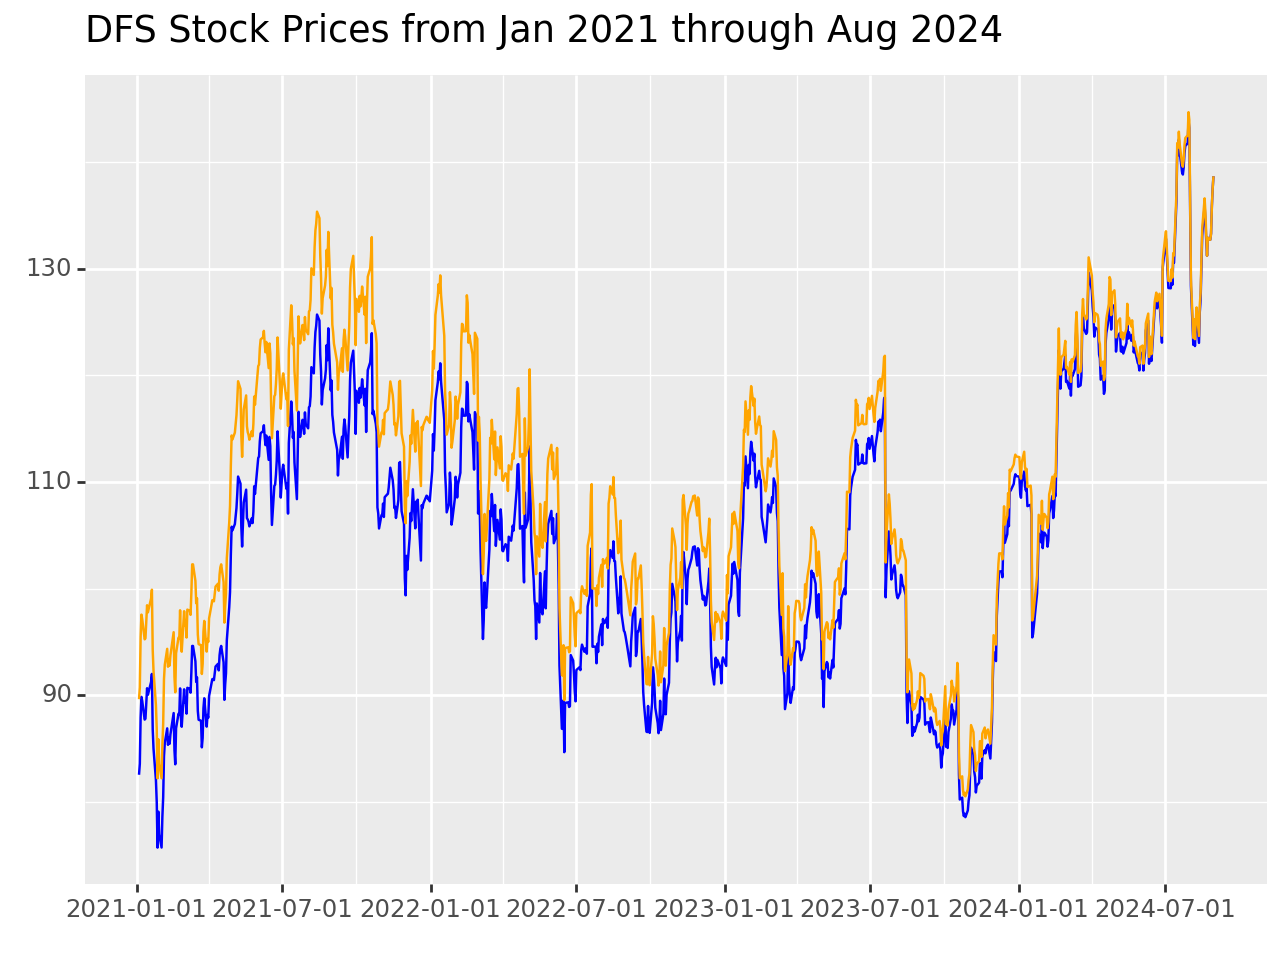

In [5]:
# Step 3: Plot the data

prices_figure = (
    pn.ggplot(processed_prices, 
              pn.aes(x="date")) +  # Common x aesthetic for both lines
    pn.geom_line(pn.aes(y="adjclose"), color="blue") +  # Adjusted close line
    pn.geom_line(pn.aes(y="close"), color="orange") +  # Unadjusted close line
    pn.labs(
        x="", y="", 
        title="DFS Stock Prices from Jan 2021 through Aug 2024",
        color="Price Type"
    ) +
    pn.scale_color_manual(values=["blue", "orange"]) + 
    pn.theme(legend_position='right')
)

prices_figure.draw()


In [6]:
# Add a series to help compare adjclose and close
processed_prices['adjclose_close_difference'] = processed_prices['adjclose'] - processed_prices['close']

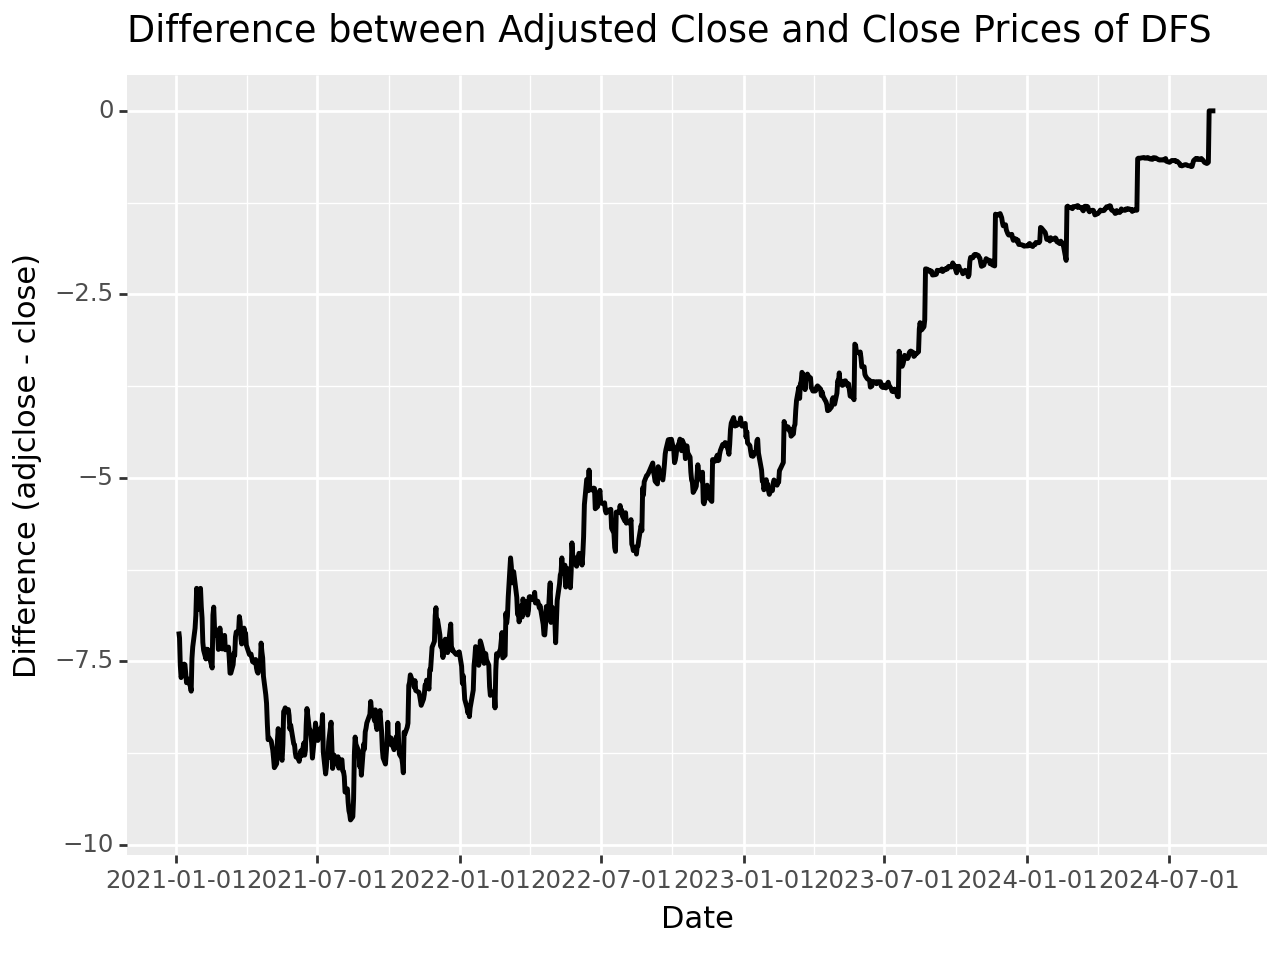

In [7]:
# Step 4: Plot the difference between adjclose and close

difference_plot = (
    pn.ggplot(processed_prices, pn.aes(x='date', y='adjclose_close_difference')) +  # Set x and y aesthetics
    pn.geom_line(color='black', size=1) +  
    pn.labs(
        x="Date", 
        y="Difference (adjclose - close)", 
        title="Difference between Adjusted Close and Close Prices of DFS"
    ) +
    pn.theme(legend_position='none')  # Remove the legend as it's not needed for a single series
)

# Draw the plot
difference_plot.draw()


The differences between adjusted and unadjusted close prices for DFS may track with dividend payments. I'm not able to trace other corporate actions that may explain the differences.

### Question 2
Compute daily net returns for an asset of your choice an dvisualize the distribution of daily returns in a histogram using 100 bins. Also, use `geom_vline()` to add a dashed red vertical line that indicates the five percent quantile of the daily returns. Compute summary statistics (mean, standard deviation, minimum and maximum) for the daily returns.

In [8]:
# We'll continue to use DFS

# Create returns df
returns = (processed_prices
           .sort_values("date")
           .assign(returns=lambda x: x["adjclose"].pct_change())
           .get(["symbol", "date", "returns"])
          )

returns = returns.dropna()

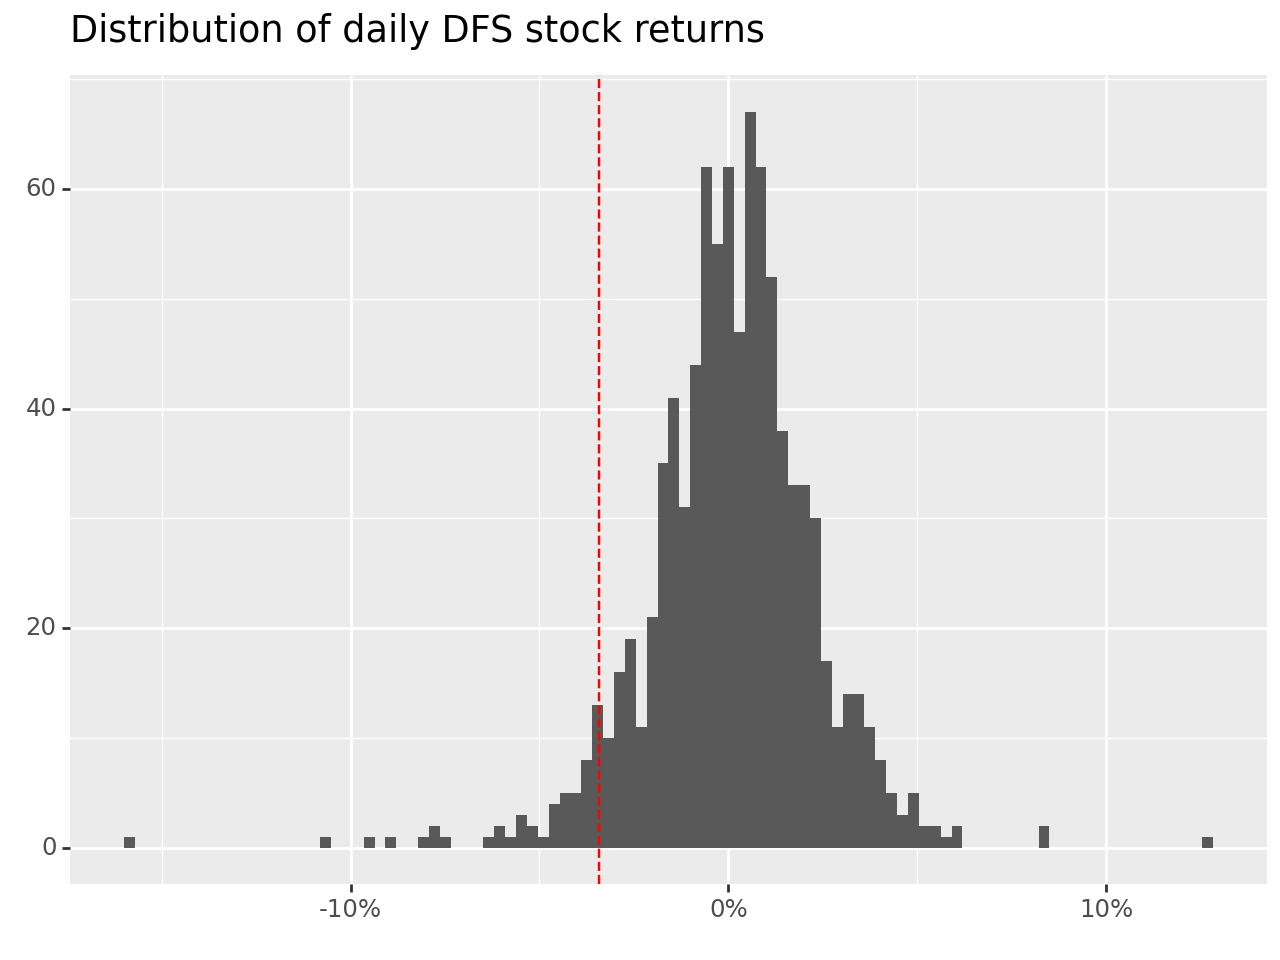

In [9]:
from mizani.formatters import percent_format

# Specify the quantile cut-off
quantile_05 = returns["returns"].quantile(0.05)


returns_figure = (
    pn.ggplot(returns, pn.aes(x="returns")) +
    pn.geom_histogram(bins=100) + # 100 bin histogram
    pn.geom_vline(pn.aes(xintercept=quantile_05),
                         linetype="dashed",
                         color="red") + # Apply red and dashed styles
    pn.labs(x="", y="",
            title="Distribution of daily DFS stock returns") +
    pn.scale_x_continuous(labels=percent_format())
)

returns_figure.draw()

The historical five percent quantile is at roughly the -3.4% mark.

In [10]:
# Compute summary statistics for the daily returns

pd.DataFrame(returns["returns"].describe()).loc[["mean", "std", "min", "max"]].round(3).T

,mean,std,min,max
returns,0.001,0.022,-0.159,0.126


Mean daily returns are +0.1% with a standard deviation of &plusmn;2.2%. The worst daily return was -15.9% while the best daily return was +12.6%.

### Question 3

Take your code from before and generalize it such that you can perform all the computations for an arbitrary vector of tickers (e.g., `ticker = ["AAPL", "MMM", "BA"]`). Automate the download, the plot of the price time series, and create a table of return summary statistics for this arbitrary number of assets.

In [11]:
# Establish vars for yf.download input

symbols = ["AFRM", "SQ", "DFS", "AXP"]
start_date = "2021-01-01"
end_date = "2024-09-01"

In [12]:
# Step 1: Downloading the Data
raw_prices = yf.download(
    tickers=symbols,
    start=start_date,
    end=end_date,
    progress=False
)

In [13]:
# Step 2: Processing the Data

# Define a function that can handle single or multiple tickers
def process_prices(df, symbols):
    if len(symbols) < 1:
        return sys.exit('Symbol list must have at least 1 ticker')
    else:
        output_df = df.copy()
        # Melt and pivot data to put it in the tidy format
            # If there's only one ticker, then the data frame yfinance puts out doesn't include it, so we add it manually
        if len(symbols) < 2: 
            output_df = output_df.melt(ignore_index=False, var_name="variable")
            output_df["symbol"] = symbols[0]
        else:
            output_df = output_df.melt(ignore_index=False, var_name=["variable", "symbol"])
    output_df = output_df.reset_index()
    output_df = output_df.pivot(index=["Date", "symbol"], columns="variable", values="value").reset_index()

    # Renaming columns more efficiently using a dictionary comprehension
    output_df = output_df.rename(columns={col: col.lower().replace(' ', '') for col in output_df.columns})
    return output_df


processed_prices = process_prices(df=raw_prices, symbols=symbols)

In [14]:
# Step 3: Plot the data

 # We need to do some string formatting to make sure the plot titles / subtitles are sensible
initial_string = "Stock Prices of"

# Generate the formatted values string using a list comprehension
formatted_values = (
    ", ".join([sym for sym in symbols[:-1]]) + " and " + symbols[-1] if len(symbols) > 1 
    else symbols[0] if symbols 
    else ""
)

# Combine the initial string with the formatted values
title_string = f"{initial_string} {formatted_values}" if formatted_values else initial_string

# Now for the subtitle with formatted date ranges
from datetime import datetime

# Convert strings to datetime objects
start_dt = datetime.strptime(start_date, "%Y-%m-%d")
end_dt = datetime.strptime(end_date, "%Y-%m-%d")

# Format the dates to "Month Year"
start_formatted = start_dt.strftime("%b %Y")
end_formatted = end_dt.strftime("%b %Y") 

# Combine the formatted strings
subtitle_string = f"{start_formatted} through {end_formatted}"


C:\Users\jakel\anaconda3\envs\tidy_finance_environment\lib\site-packages\plotnine\geoms\geom_path.py:98: PlotnineWarning: geom_path: Removed 7 rows containing missing values.


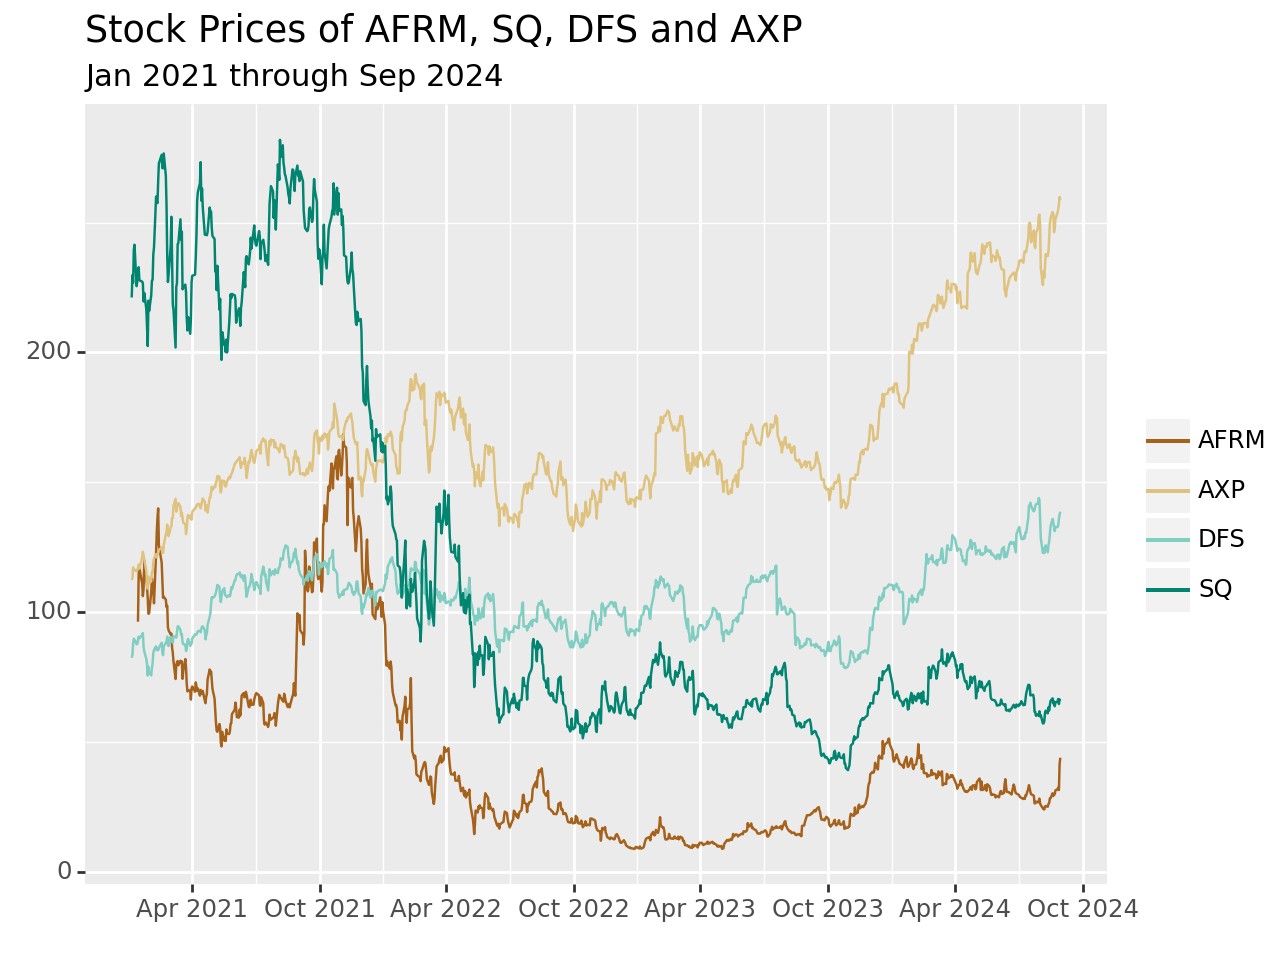

In [15]:
# Do the actual plotting

prices_figure = (
    pn.ggplot(processed_prices, 
              pn.aes(y="adjclose", x="date", color="symbol")) +  # color by ticker
    pn.geom_line() +  
    pn.labs(
        x="", y="", color = "",
        title=title_string,
        subtitle=subtitle_string
    ) +
    pn.theme(legend_position='right') +
    pn.scale_x_datetime(date_breaks="6 months", date_labels="%b %Y") +
    pn.scale_color_brewer(type='div', palette = "BrBG")

)

prices_figure.draw()


In [16]:
# Step 4: Compute returns

# Create returns df
all_returns = (processed_prices
           .sort_values("date")
           .assign(returns=lambda x: x.groupby("symbol")["adjclose"].pct_change())
           .get(["symbol", "date", "returns"])
           .dropna(subset="returns")
          )

C:\Users\jakel\AppData\Local\Temp\ipykernel_22276\552259101.py:6: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.


In [17]:
# Compute summary statistics for the daily returns

(all_returns
 .groupby("symbol")["returns"]
 .describe()
 .round(3)
).T.loc[["mean", "std", "min", "max"]].T

,mean,std,min,max
symbol,,,,
AFRM,0.001,0.066,-0.226,0.467
AXP,0.001,0.018,-0.086,0.105
DFS,0.001,0.022,-0.159,0.126
SQ,-0.001,0.040,-0.156,0.261


### Question 4

Are days with high aggregate trading volume often also days with large absolute returns? Find an appropriate visualization to analyze the question using the ticker AAPL.

In [18]:
# Establish vars for yf.download input

symbols = ["AAPL"]
start_date = "2014-01-01"
end_date = "2024-09-01"

In [19]:
# Step 1: Downloading the Data
raw_prices = yf.download(
    tickers=symbols,
    start=start_date,
    end=end_date,
    progress=False
)

In [20]:
# Step 2: Processing the Data

# Define a function that can handle single or multiple tickers
def process_prices(df, symbols):
    if len(symbols) < 1:
        return sys.exit('Symbol list must have at least 1 ticker')
    else:
        output_df = df.copy()
        # Melt and pivot data to put it in the tidy format
            # If there's only one ticker, then the data frame yfinance puts out doesn't include it, so we add it manually
        if len(symbols) < 2: 
            output_df = output_df.melt(ignore_index=False, var_name="variable")
            output_df["symbol"] = symbols[0]
        else:
            output_df = output_df.melt(ignore_index=False, var_name=["variable", "symbol"])
    output_df = output_df.reset_index()
    output_df = output_df.pivot(index=["Date", "symbol"], columns="variable", values="value").reset_index()

    # Renaming columns more efficiently using a dictionary comprehension
    output_df = output_df.rename(columns={col: col.lower().replace(' ', '') for col in output_df.columns})
    return output_df


processed_prices = process_prices(df=raw_prices, symbols=symbols)

In [21]:
# Compute trading volume (shares x prices) and scale it in billions of dollars
processed_prices["trading_volume"] = processed_prices["volume"]*processed_prices["adjclose"]/1e9

In [22]:
# Compute returns
processed_prices["returns"] = processed_prices.sort_values("date")["adjclose"].pct_change()

In [23]:
# Drop NA
processed_prices = processed_prices.dropna(subset="returns")

In [24]:
# Compute absolute returns. We care about whether high trading volumes translate into higher magnitudes of returns, whether positive or negative.
processed_prices["abs_returns"] = processed_prices["returns"].abs()

In [25]:
# Compute a squared absolute returns in case, when we compute our best fit line, we want to fit a polynomial curve.
processed_prices["trading_volume_squared"] = processed_prices["trading_volume"]**2

In [26]:
# Step 3: Plot the data

from mizani.formatters import currency_format
import statsmodels.api as sm

# First we'll do some set-up to format the line of best fit

# Fit the linear model for best fit line annotation
X = processed_prices['trading_volume']
#X = processed_prices[['trading_volume', 'trading_volume_squared']] # Used for a polynomial fit
y = processed_prices['abs_returns']
X = sm.add_constant(X)  # Adds a constant term to the predictor
model = sm.OLS(y, X).fit()
intercept, slope = model.params
#intercept, slope1, slope2 = model.params # Used for a polynomial fit

# Calculate R^2
r_squared = model.rsquared

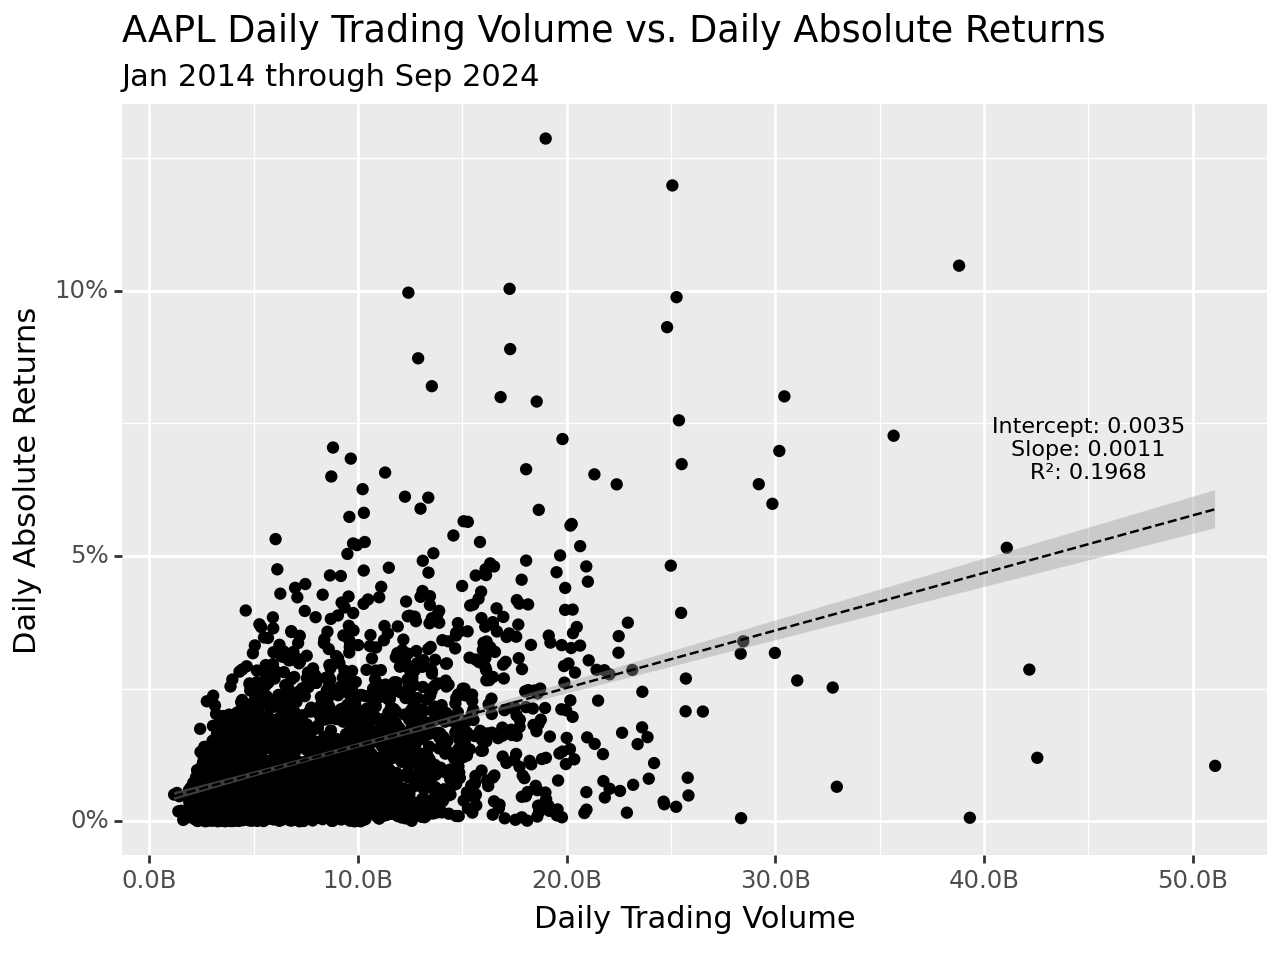

In [27]:
# Do the actual plotting

volume_vs_returns_figure = (
    pn.ggplot(processed_prices, 
              pn.aes(x="trading_volume", y="abs_returns")) +  
    pn.geom_point() +
    #pn.geom_smooth(method='lm', formula='y ~ x + I(x**2)', se=False, color='blue', linetype='dashed', size=0.5) +  # # Used for a polynomial fit
    pn.geom_smooth(method='lm', se=True, linetype="dashed", size=0.5) +  # Add a line of best fit
    pn.labs(
        x="Daily Trading Volume", 
        y="Daily Absolute Returns", 
        title="AAPL Daily Trading Volume vs. Daily Absolute Returns",
        subtitle="Jan 2014 through Sep 2024"
    ) +
    pn.scale_x_continuous(labels=currency_format(prefix="", suffix="B", big_mark=",", digits=1)) +
    pn.scale_y_continuous(labels=percent_format()) +
    pn.annotate('text', x=45, y=0.07, label=f'Intercept: {intercept:.4f}\nSlope: {slope:.4f}\nR²: {r_squared:.4f}', size=8)
)

volume_vs_returns_figure.draw()

Days with high trading volume do appear to coincide with days with high, absolute returns. That said, there is considerable noise and many of the days with the highest absolute returns do not seem to coincide with days with the highest trading volume. There's probably another relationship at play here.

### Question 5

- Compute monthly returns from the downloaded stock market prices.
- Compute the vector of historical average returns and the sample variance-covariance matrix.
- Compute the minimum variance portfolio weights and the portfolio volatility and average returns.
- Visualize the mean-variance efficient frontier.
- Choose one of your assets and identify the portfolio which yields the same historical volatility but achieves the highest possible average return.

In [28]:
# We'll follow along with the book steps to get the DOW Jones constituents, just so we have a reasonably sized index to work with

# Step 1: Download DOW constituents and the corresponding prices
url = ("https://www.ssga.com/us/en/institutional/library-content/products/fund-data/etfs/us/holdings-daily-us-en-dia.xlsx")
symbols = (pd.read_excel(url, skiprows=4, nrows=30)
           .get("Ticker")
           .tolist()
)

index_prices = yf.download(
    tickers=symbols,
    start="2000-01-01",
    end="2022-12-31",
    progress=False
)

In [29]:
# Step 2: Processing the Data

# Define a function that can handle single or multiple tickers
def process_prices(df, symbols):
    if len(symbols) < 1:
        return sys.exit('Symbol list must have at least 1 ticker')
    else:
        output_df = df.copy()
        # Melt and pivot data to put it in the tidy format
            # If there's only one ticker, then the data frame yfinance puts out doesn't include it, so we add it manually
        if len(symbols) < 2: 
            output_df = output_df.melt(ignore_index=False, var_name="variable")
            output_df["symbol"] = symbols[0]
        else:
            output_df = output_df.melt(ignore_index=False, var_name=["variable", "symbol"])
                
    output_df = output_df.reset_index()
    output_df = output_df.pivot(index=["Date", "symbol"], columns="variable", values="value").reset_index()

    # Renaming columns more efficiently using a dictionary comprehension
    output_df = output_df.rename(columns={col: col.lower().replace(' ', '') for col in output_df.columns})
    return output_df


processed_prices = process_prices(df=index_prices, symbols=symbols)

In [30]:
# Exclude constituents for which we do not observe a price on every single trading day since the year 2000

prices = (processed_prices
          .groupby("symbol")
          .apply(lambda x: x.assign(counts=x["adjclose"].dropna().count()))
                 .reset_index(drop=True)
                 .query("counts == counts.max()")
                )

In [31]:
print("Before exclusion, there were {} constituents and after exclusion there are now {} constituents."
      .format(processed_prices["symbol"].nunique(), prices["symbol"].nunique())
)

Before exclusion, there were 30 constituents and after exclusion there are now 27 constituents.


In [32]:
# 1. Compute the returns matrix
 # Compute monthly returns from the downloaded stock market prices.
returns_matrix = (prices
                  .pivot(columns="symbol", values="adjclose", index="date")
                  .resample("m")
                  .last()
                  .pct_change()
                  .dropna()
)

In [33]:
# 2. Compute the vector of historical average returns and the sample variance-covariance matrix.

mu = np.array(returns_matrix.mean()).T
sigma = np.array(returns_matrix.cov())

In [34]:
# 3. Compute the minimum variance portfolio weights and the portfolio volatility and average returns.

N = returns_matrix.shape[1]
iota = np.ones(N)
sigma_inv = np.linalg.inv(sigma)

# MVP weights
mvp_weights = sigma_inv @ iota
mvp_weights = mvp_weights/mvp_weights.sum()

# Portfolio vol and avg returns
mvp_volatility = np.sqrt(mvp_weights.T @ sigma @ mvp_weights)
mvp_return = mu.T @ mvp_weights

In [35]:
# 4. Visualize the mean-variance efficient frontier.

# Preliminary calculations
benchmark_multiple = 3 # Just an example
mu_bar = benchmark_multiple*mvp_return
C = iota.T @ sigma_inv @ iota
D = iota.T @ sigma_inv @ mu
E = mu.T @ sigma_inv @ mu
lambda_tilde = 2*(mu_bar-D/C)/(E-D**2/C)
efp_weights = mvp_weights+lambda_tilde/2*(sigma_inv @ mu-D*mvp_weights)

length_year = 12
a = np.arange(-0.4, 2.5, 0.01)
res = pd.DataFrame(columns=["mu", "sd"], index=a).astype(float)

for i in a:
    w = (1-i)*mvp_weights+i*efp_weights
    res.loc[i, "mu"] = (w.T @ mu)*length_year
    res.loc[i, "sd"] = np.sqrt(w.T @ sigma @ w)*np.sqrt(length_year)
    
# Annualize (why not?) using the simple assumption that monthly returns are iid so that we can multiply by 12
mvp_return_annual = (mu.T @ mvp_weights)*length_year
mvp_volatility_annual = (np.sqrt(mvp_weights.T @ sigma @ mvp_weights)*
                         np.sqrt(length_year))

efp_return = mu_bar*length_year
efp_volatility = (np.sqrt(efp_weights.T @ sigma @ efp_weights)*np.sqrt(length_year))

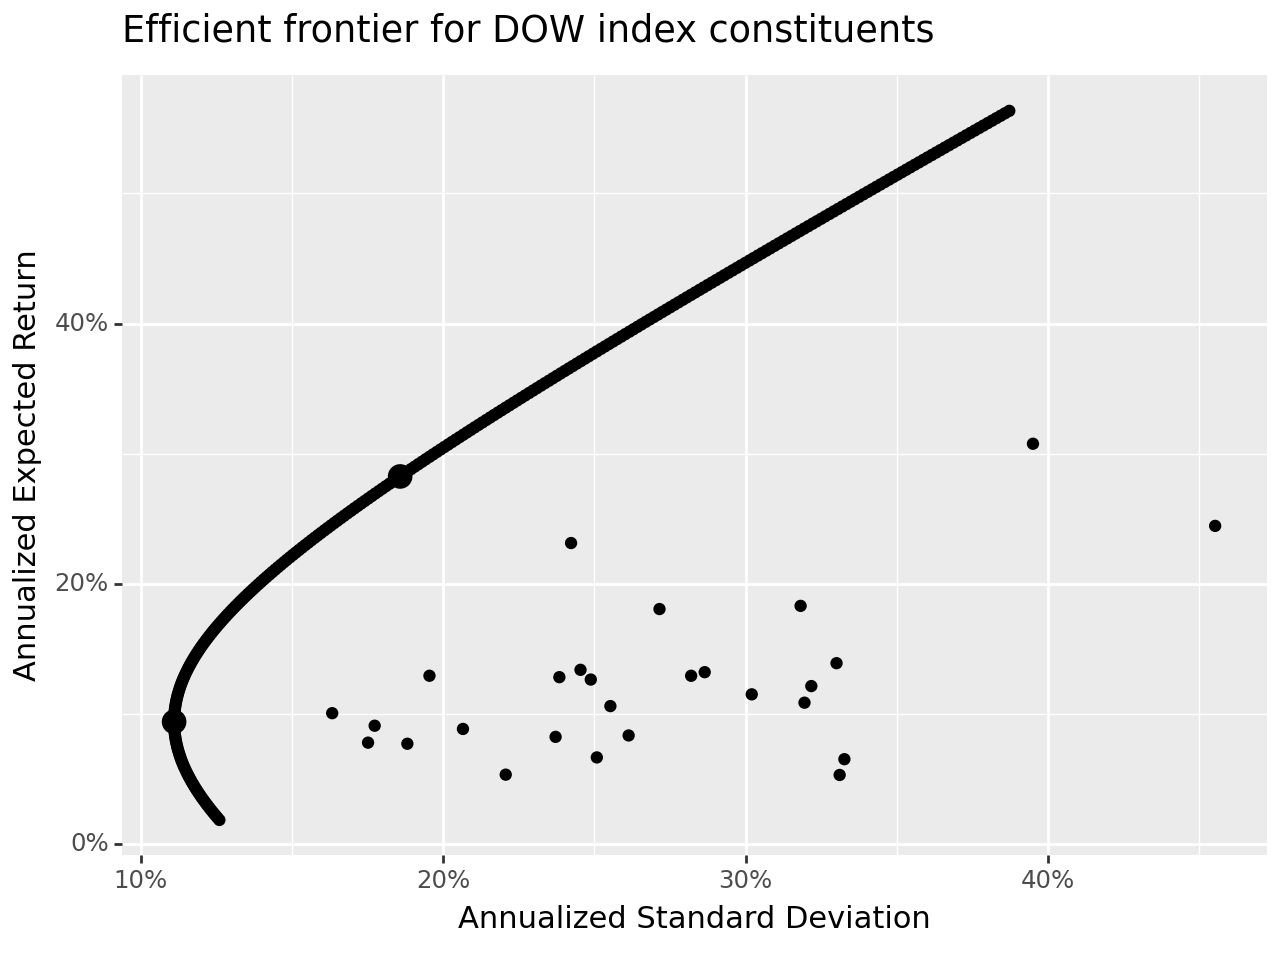

In [36]:
# Plot the figure
title_string = "Efficient frontier for DOW index constituents"

res_figure = (
    pn.ggplot(res, 
              pn.aes(x="sd", y="mu")) +
    pn.geom_point() +  
    pn.geom_point(
        pd.DataFrame({"mu": [mvp_return_annual, efp_return],
                      "sd": [mvp_volatility_annual, efp_volatility]}),
        size=4
    ) +
    pn.geom_point(
        pd.DataFrame({"mu": mu*length_year,
                      "sd": np.sqrt(np.diag(sigma))*np.sqrt(length_year)})
    ) +
    pn.labs(
        x="Annualized Standard Deviation",
        y="Annualized Expected Return",
        title=title_string
    ) +
    pn.scale_x_continuous(labels=percent_format()) +
    pn.scale_y_continuous(labels=percent_format())
)

res_figure.draw()

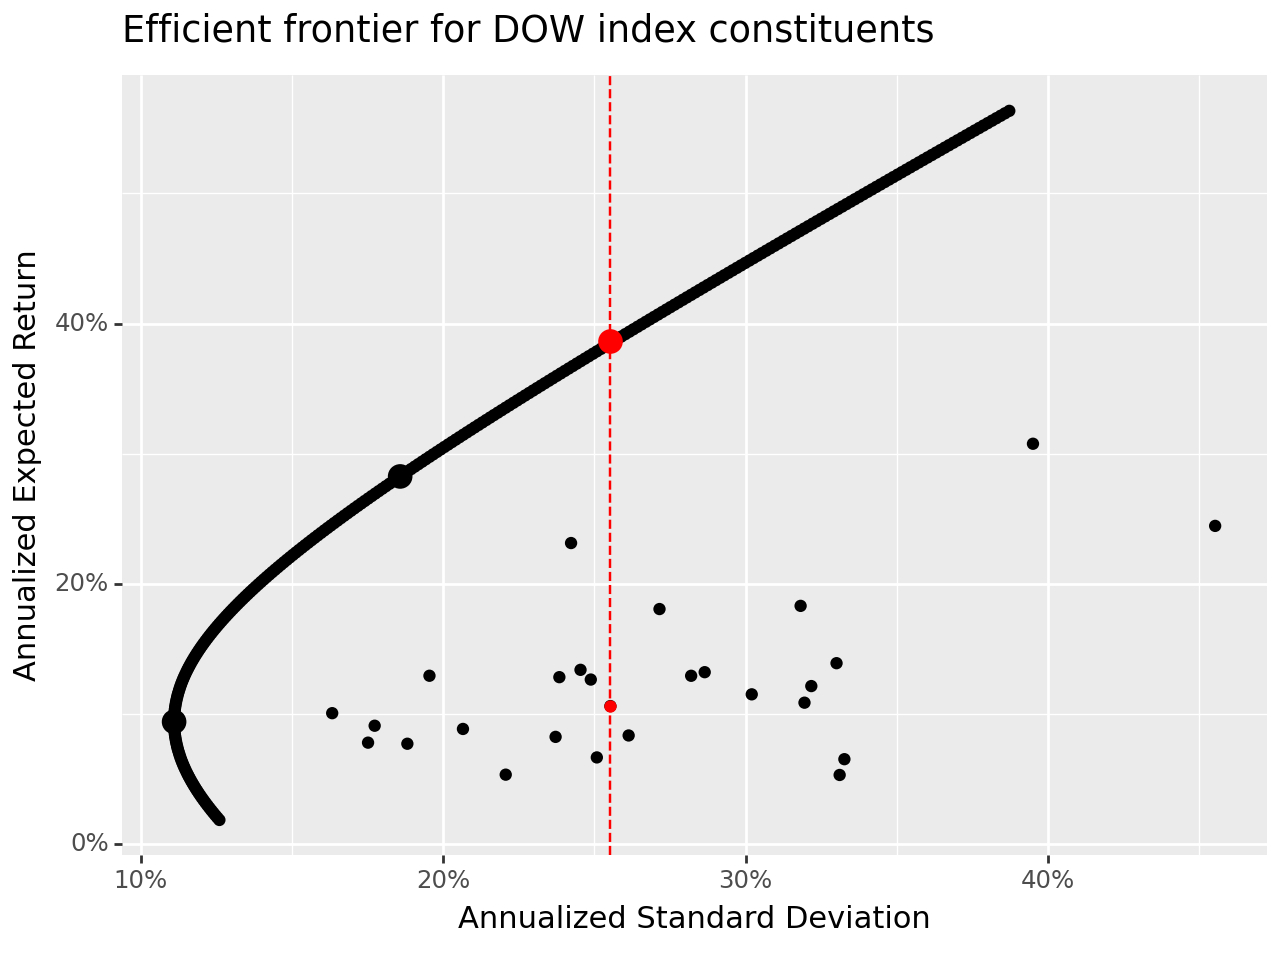

In [37]:
# Choose one of your assets and identify the portfolio which yields the same historical volatility but achieves the highest possible average return.
 # Choose a particular asset and plot it's intersection on the frontier by standard deviation
historical_volatility = np.sqrt(sigma[1][1])*np.sqrt(length_year)

 # Find the corresponding point along the frontier with that standard deviation
intersection_point = res[(res['sd'] >= historical_volatility*.9995) & (res['sd'] <= historical_volatility*1.005)].index
ef_return = res['mu'].loc[intersection_point].iloc[0]

# Plot a vertical line where the historical volatility of the target asset is and a bold red dot where the intersection point is with the frontier
res_figure_2 = res_figure + pn.geom_vline(pn.aes(xintercept=historical_volatility), 
                                  linetype="dashed",
                                  color="red") 
res_figure_2 = res_figure_2 + pn.geom_point(
                      pd.DataFrame({"mu": [ef_return],
                                    "sd": [historical_volatility]}),
                        color="red",
                        size=4
                    )

# Color the point for the original asset red
res_figure_2 = res_figure_2 + pn.geom_point(
                      pd.DataFrame({"mu": [mu[1]*length_year],
                                    "sd": [historical_volatility]}),
                        color="red"
                    )

res_figure_2.draw()

### Question 6

In the portfolio choice analysis, we restricted our sample to all assets trading every day since 2000. How is such a decision a problem when you want to infer future expected portfolio performance from the results?

Excluding assets that were delisted or companies that went out of business would tend to bias your returns upward. Similarly, excluding new listings or businesses could mean we miss out on higher returning assets. We'll compare returns with and without the assets that did not trade every day since 2000 to illustrate the impact of our decision to limit our universe to assets trading every day since 2000.

In [38]:
print("Before exclusion, there were {} constituents and after exclusion there are now {} constituents."
      .format(processed_prices["symbol"].nunique(), prices["symbol"].nunique())
)

Before exclusion, there were 30 constituents and after exclusion there are now 27 constituents.


In [39]:
# Use a loop to perform the same steps for both dataframes

for df in [processed_prices, prices]:
    # Convert `date` fields to datetime for each dataframe
    df['date'] = pd.to_datetime(df['date'])
    
    # Step 1: Calculate daily returns for each ticker
    df['returns'] = df.groupby('symbol')['adjclose'].pct_change()

    # Step 2: Calculate dollar volume for each stock
    df['dollar_volume'] = df['adjclose'] * df['volume']

# Step 3: Compute dollar-volume weighted returns for each date
weighted_returns_processed_prices = (
    processed_prices.groupby('date')
    .apply(lambda x: (x['returns'] * x['dollar_volume']).sum() / x['dollar_volume'].sum())
    .reset_index(name='dollar_volume_weighted_returns')
)

weighted_returns_prices = (
    prices.groupby('date')
    .apply(lambda x: (x['returns'] * x['dollar_volume']).sum() / x['dollar_volume'].sum())
    .reset_index(name='dollar_volume_weighted_returns')
)

C:\Users\jakel\AppData\Local\Temp\ipykernel_22276\620030394.py:8: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.


In [40]:
# Join into one dataframe
merged_returns = pd.merge(weighted_returns_processed_prices, weighted_returns_prices, on='date', how='inner')

In [41]:
merged_returns = merged_returns.rename(
    columns={
        'dollar_volume_weighted_returns_x': 'WA Returns - Exclusion',
        'dollar_volume_weighted_returns_y': 'WA Returns - No Exclusion'
    }
)

merged_returns = pd.melt(
    merged_returns,
    id_vars=['date'],  # Columns to keep fixed
    value_vars=['WA Returns - Exclusion', 'WA Returns - No Exclusion'],  # Columns to melt
    var_name='variable',  # Name of the new column to indicate the variable names
    value_name='dollar_volume_weighted_returns'  # Name of the new column to indicate values
)

In [42]:
# Calculate cumulative returns
merged_returns['cumulative_returns'] = (
    merged_returns.groupby('variable', group_keys=False)['dollar_volume_weighted_returns']
    .apply(lambda x: (1 + x).cumprod() - 1)
    .reset_index(drop=True)  # Reset index to match the original dataframe's index
)

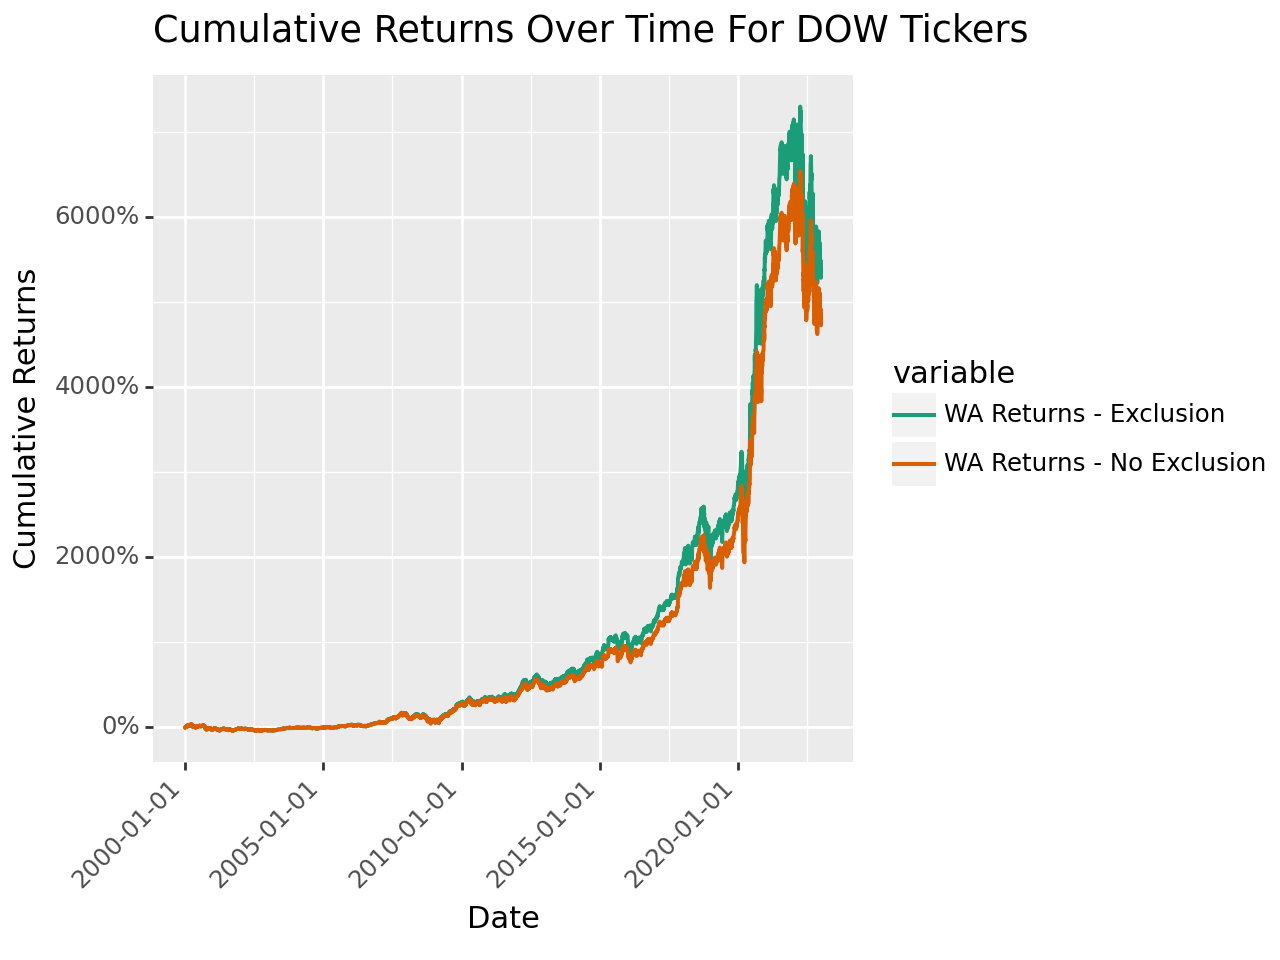

In [43]:
# Step 4: Plotting the results using plotnine
# Convert date column to datetime format
merged_returns['date'] = pd.to_datetime(merged_returns['date'])

# Plot cumulative returns over time, split by 'variable'
plot = (
    pn.ggplot(merged_returns, pn.aes(x='date', y='cumulative_returns', color='variable')) +
    pn.geom_line(size=0.8) +  # Line plot for cumulative returns
    pn.labs(
        title='Cumulative Returns Over Time For DOW Tickers',
        x='Date',
        y='Cumulative Returns'
    ) +
    pn.scale_y_continuous(labels=percent_format()) +  # Format y-axis as percentage
    pn.theme(legend_position='right') +
    pn.scale_color_brewer(type='qual', palette='Dark2') +
    pn.theme(axis_text_x=pn.element_text(rotation=45, hjust=1))  # Rotate x-axis labels for better readability
)

# Draw the plot
plot.draw()

We can see that by excluding the 3 tickers that did not have prices for the full time range, we inflated our cumulative returns. This may lead us to develop strategies that will not perform as we expect in production.

### Question 7

The efficient frontier characterizes the portfolios with the highest expected return for different levels of risk. Identify the portfolio with the highest expected return per standard deviation. Which famous performance measure is close to the ratio of average returns to the standard deviation of returns?

In [44]:
res["sharpe"] = res["mu"]/res["sd"]

In [45]:
max_sharpe_row = res.loc[res['sharpe'].idxmax()]

In [46]:
max_sharpe_row

mu        0.303379
sd        0.199206
sharpe    1.522941
Name: 1.1100000000000012, dtype: float64

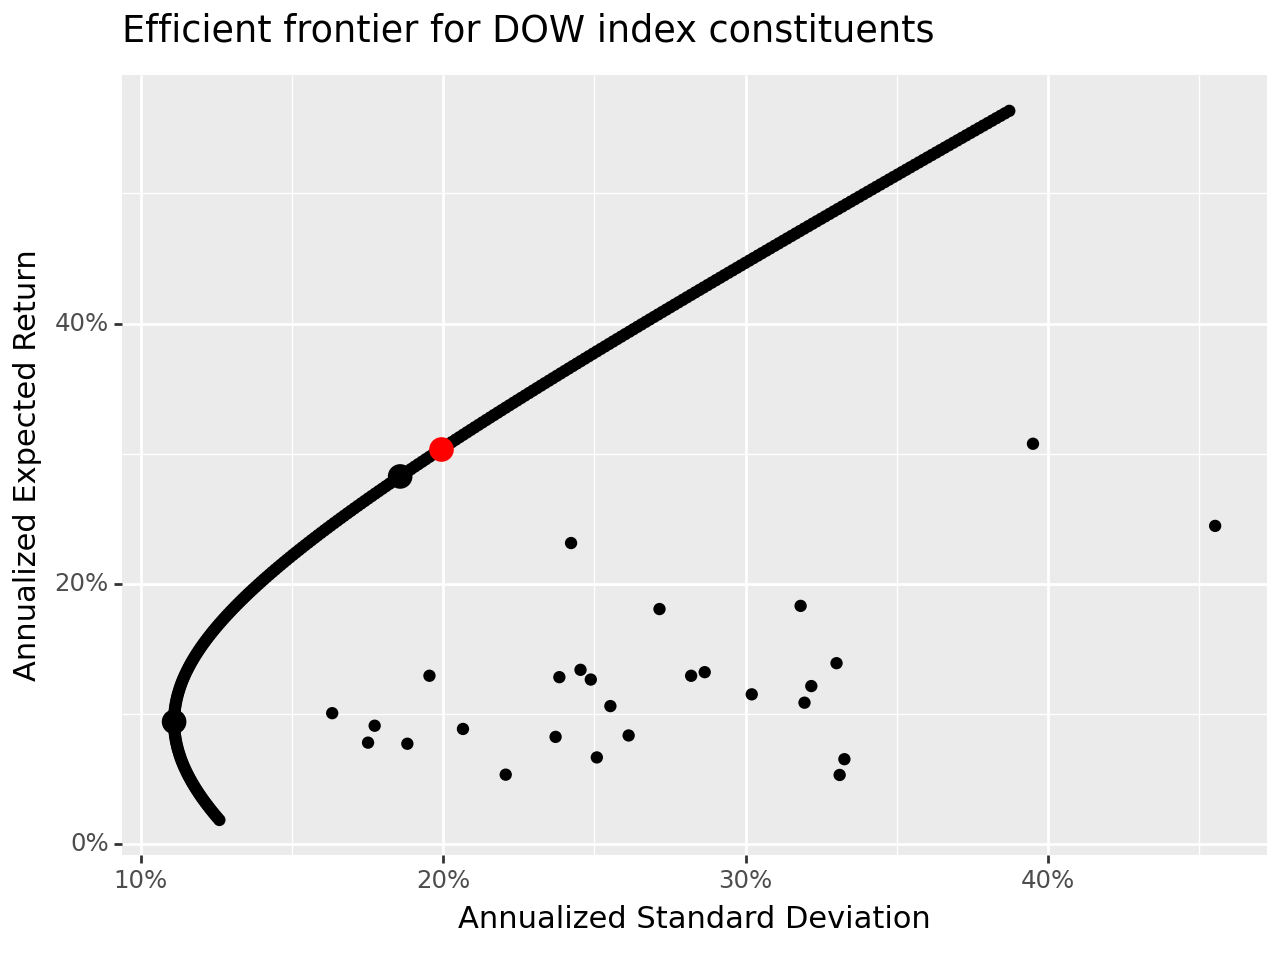

In [49]:
# Plot the figure
title_string = "Efficient frontier for DOW index constituents"

sharpe_figure = (
    pn.ggplot(res, 
              pn.aes(x="sd", y="mu")) +
    pn.geom_point() +  
    pn.geom_point(
        pd.DataFrame({"mu": [mvp_return_annual, efp_return],
                      "sd": [mvp_volatility_annual, efp_volatility]}),
        size=4
    ) +
    pn.geom_point(
        pd.DataFrame({"mu": mu*length_year,
                      "sd": np.sqrt(np.diag(sigma))*np.sqrt(length_year)})
    ) +
    pn.labs(
        x="Annualized Standard Deviation",
        y="Annualized Expected Return",
        title=title_string
    ) +
    pn.scale_x_continuous(labels=percent_format()) +
    pn.scale_y_continuous(labels=percent_format())
)


# Plot where the portfolio with the highest expected return per standard deviation falls on the efficient frontier

sharpe_figure = sharpe_figure + pn.geom_point(
                      pd.DataFrame({"mu": [max_sharpe_row["mu"]],
                                    "sd": [max_sharpe_row["sd"]]}),
                        color="red",
                        size=4
                    )

sharpe_figure.draw()

The Sharpe Ratio is the famous performance measure we're talking about here. 

$$$
S_{a} = \frac{E[R_{a} - R_{b}]}{\sigma_{a}} = \frac{E[R_{a} - R_{b}]}{\sqrt{\mathrm{var}[R_{a} - R_{b}]}}
$$


In this case, we're using only the gross expected returns and not the returns in excess of the risk free rate, but in a situation where the risk free rate is ~0, our approximation is "close enough".